# Parallelization of Simulation and Optimization

For the sake of simplicity, we import classes from the standard use case of rabi
driving in the rotating frame with xy control, as this section focuses solely on
the parallelization.

## Parallel evaluation of Monte Carlo simulations

Monte Carlo simulations can become very costly, if many noise traces are
required to suppress statistical uncertainties and the pulse needs to be sampled
at very small time steps $\delta t$ to increase the maximal noise frequency
which can be resolved $f_{max} = 1/ \delta t$.

In [11]:
from qopt.examples.rabi_driving.rabi_xy_setup import *
import time

n_pulses = 10
random_pulses = np.random.rand(n_pulses, n_time_samples, len(qs_solver.h_ctrl))

monte_carlo_solver = solver_colored_noise_xy
monte_carlo_solver.set_optimization_parameters(random_pulses[0])

In [12]:
monte_carlo_solver.processes = 1
start = time.time()
_ = monte_carlo_solver.propagators
end = time.time()
print('sequentiel execution')
print(end - start)

sequentiel execution
45.85082268714905


In [13]:
# If we do not set new optimization parameters, the solver will return the
# stored propagators from the previous call.
monte_carlo_solver.set_optimization_parameters(0 * random_pulses[0])
monte_carlo_solver.set_optimization_parameters(random_pulses[0])

# By setting the number of processes to None, the program uses the number of
# kernels in your CPU.
monte_carlo_solver.processes = None
start = time.time()
_ = monte_carlo_solver.propagators
end = time.time()
print('parallel execution')
print(end - start)

parallel execution
22.144206047058105


## Parallel Optimization

Gradient based optimization algorithms tend to require many different initial
values because they tend to get stuck in local minima.

parallel execution
212.82319736480713
Total execution time:
954.2426476478577


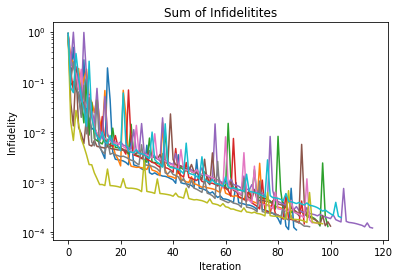

In [5]:
from qopt import *

n_optimizations = 10
random_pulses = np.random.rand(
    n_optimizations, n_time_samples, len(qs_solver.h_ctrl))

start = time.time()
data = run_optimization_parallel(optimizer, initial_pulses=random_pulses,
                                 processes=None)
end = time.time()
print('parallel execution')
print(end - start)

analyser = Analyser(data)
analyser.plot_absolute_costs()

print('Total execution time:')
print(analyser.total_cost_fkt_time() + analyser.total_grad_fkt_time())

The Computation was performed on a 6 core CPU so that a speedup of about a
factor of 4.5 is decent.

## Parallel Simulation

If you want to use just the Simulation tools then here you can find an example of
easy parallelization using the native multiprocessing package:

In [6]:
from qopt.examples.rabi_driving.rabi_xy_setup import *
from multiprocessing import Pool


n_pulses = 10
random_pulses = np.random.rand(n_pulses, n_time_samples, len(qs_solver.h_ctrl))

start_parallel = time.time()
with Pool(processes=None) as pool:
    infids = pool.map(simulate_propagation, random_pulses)
end_parallel = time.time()
parallel_time = end_parallel - start_parallel

start_sequential = time.time()
infids_sequential = list(map(simulate_propagation, random_pulses))
end_sequential = time.time()
sequential_time = end_sequential - start_sequential

In [7]:
print('parallel execution')
print(parallel_time)
print('sequential execution')
print(sequential_time)

parallel execution
138.55505537986755
sequential execution
499.32289695739746
